ANN

In [ ]:
!pip install surprise

In [ ]:
!pip install annoy

In [ ]:
from surprise import Dataset, SVD, Reader,NMF
from surprise.model_selection import cross_validate,train_test_split
from surprise.model_selection import GridSearchCV,RandomizedSearchCV
from surprise import accuracy
from hyperopt import tpe, fmin, hp, Trials, STATUS_OK,space_eval
import sys
import seaborn as sns
from timeit import Timer
from datetime import datetime
from surprise import Dataset, SVD, Reader,NMF
from surprise.model_selection import cross_validate,train_test_split
from surprise.model_selection import GridSearchCV,RandomizedSearchCV
from surprise import accuracy
import functools
from hyperopt import tpe, fmin, hp, Trials, STATUS_OK,space_eval
from collections import defaultdict
import random
from sklearn.metrics import mean_squared_error
from numpy.linalg import inv
import pandas as pd
import numpy as np
import math
from numpy.linalg import inv
from numpy.linalg import multi_dot
import matplotlib.pyplot as plt
import itertools
import warnings
warnings.filterwarnings("ignore")

In [ ]:
data = pd.read_csv('/data/sample_data.csv')

In [ ]:
data.drop(columns=['Unnamed: 0','timestamp','date','year'],inplace=True)
data

,userId,movieId,rating
0,2,849,3.5
1,339,849,5.0
2,1707,849,2.5
3,2040,849,1.0
4,2759,849,4.0
...,...,...,...
897059,279416,4090,4.0
897060,279765,4090,3.0
897061,279869,4090,3.0
897062,280137,4090,3.0


### Splitting Main dataset to a train and a test dataset

In [ ]:
user_freq=data.groupby(['userId']).size().reset_index(name='counts')
users_lt3=user_freq[user_freq['counts']<3][['userId']]
users_ge3=user_freq[user_freq['counts']>=3][['userId']]
train1 = pd.merge(data, users_lt3, on=['userId'],how='inner')
data1 = pd.merge(data, users_ge3, on=['userId'],how='inner')

random.seed(2)
test=data1.groupby('userId').sample(frac=.3, random_state=2)
test_idx = data1.index.isin(test.index.to_list())
train = train1.append(data1[~test_idx])

train_df = train
test_df = test

##  Before Applying ANN, it is a prerequisite that we have our latent matrix i.e. U and V matrices ready.
Therefore, I am reusing code from the SVD Collaborative Filtering model to get the latent matrix.

In [ ]:
reader = Reader(rating_scale=(1,5))
train = Dataset.load_from_df(train[['userId', 'movieId', 'rating']], reader=reader)
test = Dataset.load_from_df(test[['userId', 'movieId', 'rating']], reader=reader)
raw_ratings = test.raw_ratings
threshold = int(1 * len(raw_ratings))
A_raw_ratings = raw_ratings[:threshold]
test = test.construct_testset(A_raw_ratings)

In [ ]:
raw_ratings1 = train.raw_ratings
threshold = int(1 * len(raw_ratings1))
B_raw_ratings = raw_ratings1[:threshold]
train_test = train.construct_testset(B_raw_ratings)

The hyperparameters are taken from the hyperparameter optimization performed in homework 2

In [ ]:
model = SVD(n_epochs=50,n_factors=15,reg_all=0.1,lr_all=0.02)
trainset = train.build_full_trainset()
model.fit(trainset)

In [ ]:
# Retrieiving inner ids, as used by surprise package during model training
user_inner_ids = [x for x in trainset.all_users()]
item_inner_ids = [i for i in trainset.all_items()]

# All ids mapped back to values in the actual train set 
user_raw_ids = [trainset.to_raw_uid(x) for x in user_inner_ids]
item_raw_ids = [trainset.to_raw_iid(x) for x in item_inner_ids]

print(user_raw_ids[:5])
print(item_raw_ids[:5])

[16421, 260732, 102234, 115586, 137983]
[849, 2746, 256, 1186, 45447]


In [ ]:
U = model.pu 
V = model.qi
print(U[0])
print(V[0])

[-0.05302268 -0.02227303  0.05578189 -0.01359157 -0.14927086  0.35572043
  0.21943662  0.24762818 -0.14297904  0.01439977 -0.00919634  0.07778417
  0.13208344  0.03271715  0.05610183]
[-0.36837336 -0.27820455 -0.04462046  0.09576319 -0.27990917  0.33515672
  0.45887813  0.49758119 -0.5457651  -0.18949795 -0.18231612  0.0459107
  0.31084306 -0.2042985   0.03751827]


In [ ]:
print(model.pu.shape) # (n_user, n_factors)
print(model.qi.shape) # (n_items, n_factors)

(20974, 15)
(1103, 15)


# Exploratory Data Analysis

In [ ]:
# Movie frequency per user for all users in our training dataset
user_freq = train_df.groupby('userId', as_index=False).agg(num_movies=('movieId','count'))

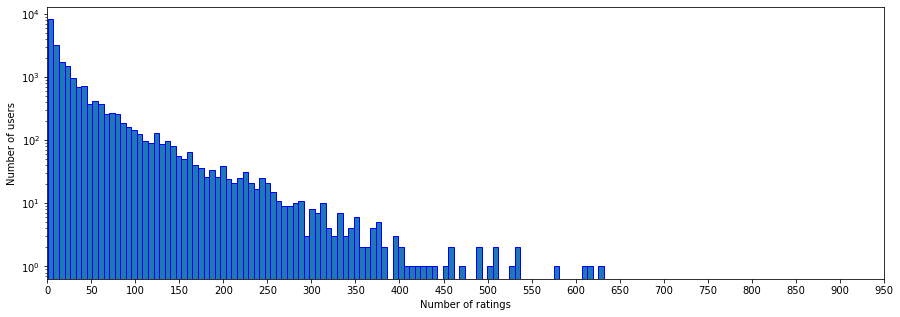

In [ ]:
plt.figure(figsize=(15,5))
plt.hist(user_freq['num_movies'], bins=100, edgecolor='b', log=True)
plt.xlim(0,)
plt.xticks(np.arange(0,1000,50))
plt.xlabel('Number of ratings')
plt.ylabel('Number of users')
plt.show()


We have a lot of users who have rated more than 50 ratings.
We will be looking at using nearest neighbours to reduce the size of the the user-movie pairs in the train dataset.

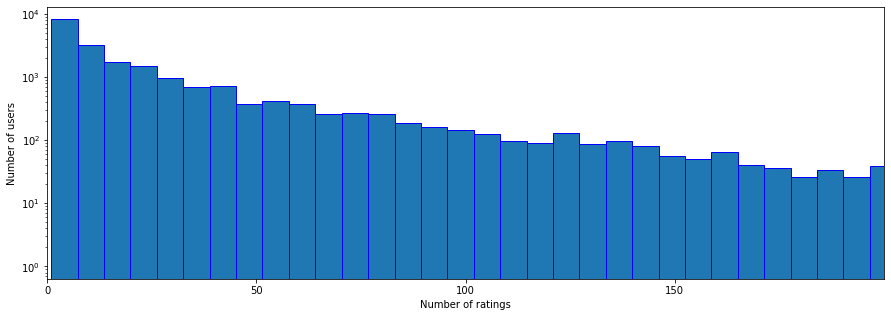

In [ ]:
plt.figure(figsize=(15,5))
plt.hist(user_freq['num_movies'], bins=100, edgecolor='b', log=True)
plt.xlim(0,200)
plt.xticks(np.arange(0,200,50))
plt.xlabel('Number of ratings')
plt.ylabel('Number of users')
plt.show()

The latent matrix is a numpy array of shape (n_items, n_factors. The first raw corresponds to the first raw item id (see this: http://surprise.readthedocs.io/en/latest/FAQ.html#what-are-raw-and-inner-ids), the second correspond to the second raw item id, etc...

# Annoy package 

Annoy is a C++ library with Python bindings that builds random projection trees. An index is built with a forest of k trees, where k is a tunable parameter that trades off between precision and performance. It also creates large read-only, file-based data structures that are mapped into memory so that many processes can share the data.

In [ ]:
from annoy import AnnoyIndex

In [ ]:
# To be used for serialized pipeline; user item search

f = 15 # n_factors
t = AnnoyIndex(f, 'angular')  # Length of item vector that will be indexed
for i,v in zip(user_inner_ids,V):
    t.add_item(i, v)

t.build(50)
t.save('test_user_item.ann')

True

In [ ]:
u = AnnoyIndex(f, 'angular')
u.load('test_user_item.ann') 
# super fast, will just map the file

True

### Creating filtered training model with reduced rows per user 

In [ ]:
user_ids_nn = list(user_freq[user_freq['num_movies']>50]['userId'].values)

In [ ]:
def find_nn_greater_than_k(user_id, k=100):
  return t.get_nns_by_vector(U[trainset.to_inner_uid(user_id)], k) 

In [ ]:
user_nn_items = list(map(find_nn_greater_than_k,user_ids_nn))
user_nn_items_dict={}
for userid,items in zip(user_ids_nn,user_nn_items):
  user_nn_items_dict[userid] = [trainset.to_raw_iid(i) for i in items]

In [ ]:
user_nn_items_df = pd.concat({k: pd.Series(v) for k, v in user_nn_items_dict.items()})
user_nn_items_df = user_nn_items_df.reset_index()
user_nn_items_df = user_nn_items_df.drop(columns=['level_1'])
user_nn_items_df.rename(columns={'level_0': 'userId', 0: 'movieId'}, inplace=True)
user_nn_items_df

,userId,movieId
0,73,1617
1,73,6016
2,73,1228
3,73,1178
4,73,1218
...,...,...
176645,283184,2467
176646,283184,1212
176647,283184,6286
176648,283184,8014


In [ ]:
merged_df= pd.merge(train_df,user_nn_items_df,how='inner',on=['userId','movieId'])
len(merged_df['userId'].unique())

3511

In [ ]:
#concatenate data for users who rated less than 50 movies merged_df
user_ids_without_nn = set(list(train_df['userId'].unique())) - set(user_ids_nn)
user_ids_without_nn_df = pd.DataFrame(user_ids_without_nn,columns =['userId']) 
len(user_ids_without_nn_df['userId'].unique())

17441

In [ ]:
user_ids_without_nn_df = pd.merge(train_df,user_ids_without_nn_df,how='inner',on='userId')
len(user_ids_without_nn_df['userId'].unique())

17441

In [ ]:
# ANN reduced matrix
train_concat_df = pd.concat([user_ids_without_nn_df, merged_df])
#train_concat_df = merged_df
train_concat_df

,userId,movieId,rating
0,16421,849,4.5
1,16421,2746,4.0
2,260732,849,3.0
3,260732,256,1.0
4,102234,1186,3.0
...,...,...,...
31839,139879,4025,3.5
31840,139879,96281,5.0
31841,139879,103141,4.0
31842,139879,132480,4.5


### End of code to produce filtered matrix

In [ ]:
def datasize(nn):

  user_ids_nn = list(user_freq[user_freq['num_movies']>50]['userId'].values)


  def find_nn_greater_than_k(user_id, k):
    return t.get_nns_by_vector(U[trainset.to_inner_uid(user_id)], k) 

  user_nn_items = list(map(find_nn_greater_than_k,user_ids_nn,itertools.repeat(nn, len(user_ids_nn))))
  user_nn_items_dict={}
  for userid,items in zip(user_ids_nn,user_nn_items):
    user_nn_items_dict[userid] = [trainset.to_raw_iid(i) for i in items]
  
  
  user_nn_items_df = pd.concat({k: pd.Series(v) for k, v in user_nn_items_dict.items()})
  user_nn_items_df = user_nn_items_df.reset_index()
  user_nn_items_df = user_nn_items_df.drop(columns=['level_1'])

  user_nn_items_df.rename(columns={'level_0': 'userId', 0: 'movieId'}, inplace=True)

  merged_df= pd.merge(train_df,user_nn_items_df,how='inner',on=['userId','movieId'])

  user_ids_without_nn = set(list(train_df['userId'].unique())) - set(user_ids_nn)
  user_ids_without_nn_df = pd.DataFrame(user_ids_without_nn,columns =['userId']) 
  user_ids_without_nn_df = pd.merge(train_df,user_ids_without_nn_df,how='inner',on='userId')

  train_concat_df = pd.concat([user_ids_without_nn_df, merged_df])
  data_size = train_concat_df.shape[0] 
  return data_size

In [ ]:
data_set_reduction = {}
data_set_reduction [60] = train_df.shape[0] - datasize(60)
data_set_reduction [80] = train_df.shape[0] - datasize(80)
data_set_reduction [100] = train_df.shape[0] -  datasize(100)
data_set_reduction [140] = train_df.shape[0] -  datasize(140)
data_set_reduction [180] = train_df.shape[0] -  datasize(180)

In [ ]:
df = pd.DataFrame(list(data_set_reduction.items()),columns = ['num_of_neighbours','dataset_size_reduction'])
df

,num_of_neighbours,dataset_size_reduction
0,60,359402
1,80,349060
2,100,339284
3,140,320596
4,180,303054


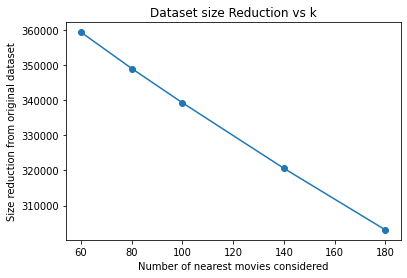

In [ ]:
plt.scatter(df['num_of_neighbours'],df['dataset_size_reduction'])
plt.plot(df['num_of_neighbours'],df['dataset_size_reduction'])
plt.xlabel("Number of nearest movies considered")
plt.ylabel("Size reduction from original dataset")
plt.title("Dataset size Reduction vs k")
plt.show()